In [1]:
# Import relevant packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import methods_py as m
import re
import sys,time

# reload to make sure we have the latest version of method.py loaded
import importlib
importlib.reload(m)

# NLTK package for stopwords
import nltk
nltk.download(['punkt', 'wordnet','stopwords'])
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# sklearn 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_precision_recall_curve, roc_auc_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
[nltk_data] <urlopen error [Errno -3] Temporary failure in name
[nltk_data]     resolution>


References Credits: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

In [2]:
# Read in the train data 
df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
# display the first 5 rows
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## 1. Explore the dataframe

In [3]:
# call custom method to explore the dataframe
m.explore_df(df)

The dataframe has  159571 rows and  8 columns 

There are  2 categorical columns and  6 numerical columns in the dataframe 

A list of all the categorical columns 

['id', 'comment_text'] 

Total number of unique values for column  id is  159571 

The first 10 unique values are ['0000997932d777bf', '000103f0d9cfb60f', '000113f07ec002fd', '00013fa6fb6ef643', '0001b41b1c6bb37e', '0001d958c54c6e35', '00024b59235015f3', '00025465d4725e87', '0002bcb3da6cb337', '0002bfc2abe2a51f']
Total number of unique values for column  comment_text is  159571 

The first 10 unique values are ["!\n\nI won't stop!  LOCK IT UP A$$HOLE", '!\n\nIt is now inside your bones, your head. Haunt you forever', "!\n\nSuck my DIHCK! Nihgga!\n\nYou don't want people to know the TRUTH about utorrant, you FAG", "!\n\nWHY DOESN'T ANYONE BAN ME \n\nBAN ME BAN ME BAN ME BANNNNNNNNNNNNNNNNNNNNNNNNNN", '!\nPlease stop reverting my edits to Wesley Holiday, if you continue to do so you will be blocked.', "!\nWant to explain to m

In [4]:
# list of columns for the labelled comment type 
df.drop(['id','comment_text'],axis=1).columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [5]:
# adding some of the ad-hoc words coming up as frequent and I want to exclude those
stop_words.update(["u","go","as","like","wikipedia","jim","hi","get"])

# tokeinze method to remove punctuations, lemmatize and remove stop words
def tokenize(text):
    '''
    INPUT
    text- the text that needs to be tokenized
    
    OUTPUT
    tokens - a list of tokenized words after cleaning up the input text
    
    This function :
    1. converts text to all lower case and removes punctuations
    2. tokenize entire text into words
    2. lemmatize each word using WordNetLemmatizer
    3. remove all stop words from text as per english corpus of stop words
    '''
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    
    return tokens

In [6]:
print(" ###### WARNING : Comments below contain strong profanity and abusive words ####### \n")

# utilizing counter to get the most common 10 words coming up in each category
for category in list(df.drop(['id','comment_text'],axis=1).columns):
    print("10 most frequent words in "+category+" comments")
    print(dict(Counter(tokenize(" ".join(df[df[category]==1].comment_text))).most_common(10)).keys())
    print("\n ********************* \n")

 ###### WARNING : Comments below contain strong profanity and abusive words ####### 

10 most frequent words in toxic comments
dict_keys(['fuck', 'suck', 'shit', 'nigger', 'fucking', 'as', 'faggot', 'hate', 'page', 'know'])

 ********************* 

10 most frequent words in severe_toxic comments
dict_keys(['fuck', 'suck', 'as', 'shit', 'faggot', 'bitch', 'fucking', 'die', 'cunt', 'nigger'])

 ********************* 

10 most frequent words in obscene comments
dict_keys(['fuck', 'suck', 'shit', 'fucking', 'as', 'nigger', 'bitch', 'faggot', 'cunt', 'dick'])

 ********************* 

10 most frequent words in threat comments
dict_keys(['die', 'as', 'kill', 'going', 'block', 'fuck', 'must', 'wale', 'supertr0ll', 'fucking'])

 ********************* 

10 most frequent words in insult comments
dict_keys(['fuck', 'suck', 'nigger', 'fucking', 'faggot', 'as', 'bitch', 'fat', 'shit', 'cunt'])

 ********************* 

10 most frequent words in identity_hate comments
dict_keys(['nigger', 'jew', 'f

In [7]:
# access custom method to explore dataframe
m.explore_null(df)

The column(s) with all null values:  set() 

 More than  25 % of values are null for columns  set() 

 More than  50 % of values are null for columns  set() 

 More than  75 % of values are null for columns  set() 



Text(0.5, 0, 'category')

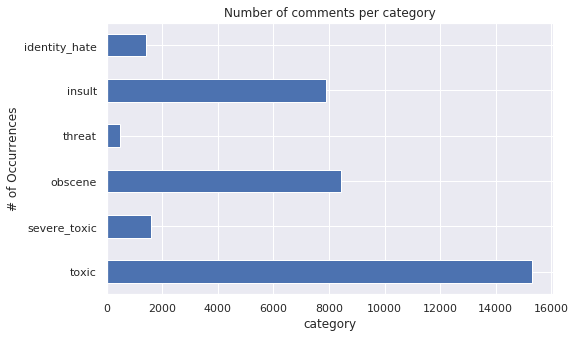

In [8]:
# Lets explore the number of comments for each category
# This gives us a quick view of how the dataset is populated

df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])

df_stats.plot(x='category', y='number_of_comments', kind='barh', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

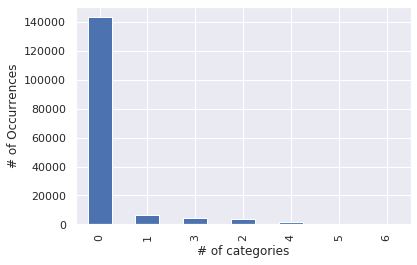

In [9]:
# How many comments have multi labels?

df.drop(['id','comment_text'],axis=1).sum(axis=1).value_counts().plot(kind='bar')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [10]:
# % of comments which are labeled

round((sum(df.drop(['id','comment_text'],axis=1).sum(axis=1) > 0)/len(df))*100,2)

10.17

Observation : This is an imbalanced set with almost 90% of comments not classified into any one of the 6 categories

Text(0.5, 0, '# of words')

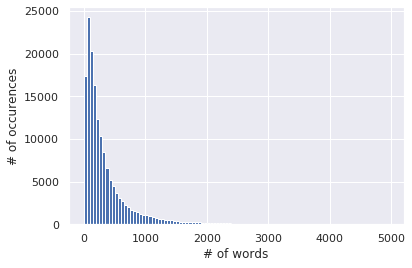

In [11]:
#The distribution of the number of words in comment texts.

lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

plt.ylabel('# of occurences', fontsize=12)
plt.xlabel('# of words', fontsize=12)

## 2. Modeling

#### We evaluate four different classification models : LinearSVC, NaiveBayes, Decision Tree Classifer and Logistic Regression 

In [12]:
# Credits: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#          https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
#          https://scikit-learn.org/stable/modules/multiclass.html
        
def build_model(model_type, c):
    '''
    INPUT
    model type - which model we want to build between Linear SVC, NaiveBayes and Logistic Regression
    
    OUTPUT
    pipeline- a pipeline built to vectorize, tokenize, transform and classify text data
    
    This function :
    1. builds a pipeline of countvectorizer, tfidf transformer, and
    2. a random forest multi output classifier
    '''
    #check the model_type provided by user
    if model_type == 'linear_svc':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(C=c), n_jobs=3))
    ])
        
    #check the model_type provided by user    
    elif model_type== 'naivebayes':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))
    ])
        
    #check the model_type provided by user    
    elif model_type== 'logistic_reg':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))
    ])
        
    #check the model_type provided by user    
    elif model_type== 'random_forest':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(RandomForestClassifier(max_depth=2, random_state=0), n_jobs=1))
    ])
        
    #check the model_type provided by user    
    elif model_type== 'decision_tree':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(DecisionTreeClassifier(random_state=0), n_jobs=1))
    ])
    
    # return the built pipeline
    return pipeline

## 3. Predict and evaluate models

Credits: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

We consider using the ROC AUC score for evaluation the model as it is an imbalanced dataset with around 90% of comments with no labels i.e. clean comments

***Although widely used, the ROC AUC is not without problems.***

For imbalanced classification with a severe skew and few examples of the minority class, the ROC AUC can be misleading. This is because a small number of correct or incorrect predictions can result in a large change in the ROC Curve or ROC AUC score.

A common alternative is the precision-recall curve and area under curve (Precision-Recall Curves and AUC)


In [13]:
def evaluate_model(model, X_test, Y_test):
    '''
    INPUT
    model : the model that needs to be evaluated
    X_test : validation data set i.e. messages in this case
    Y_test : the output data for X_test validation set i.e. 36 categories values
    category_names : the 36 category names
    
    OUTPUT
    classification report for the model based on predictions, gives
    the recall, precision and f1 score
    
    This function :
    1. utilizes the input model to make predictions
    2. compares the predictions to the test data to provide a classification report
    '''
    
    y_pred = model.predict(X_test)
    
    # ROC AUC Score
    return round(roc_auc_score(Y_test, y_pred),3)
    

In [14]:


# we will be using each one of the category below to utilize them as the Predicted value (Y)
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# we will utilize the comment text column to predict Y
X= df['comment_text']



We first try working with a Naive Bayes Model to baseline our score

In [15]:
model_type = 'naivebayes'

print("Training with a "+model_type+" model")

model_dict_nb= dict()

for category in categories:

    print(" ---------------------------------------- ")
    #print(" Working on evaluating ROC AUC score for "+category+" comments ............")
    
    # the category becomes our predicted variable
    Y= df[category]
    
    # split the data set to a train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
      
    print('Building model for ',category,' comments')
    model = build_model(model_type,1)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    print("ROC AUC Score: ",evaluate_model(model, X_test, Y_test))
            
    #save the model into a dictionary
    model_dict_nb[model] = category
    print("Model saved for ",category," comments")
    

Training with a naivebayes model
 ---------------------------------------- 
Building model for  toxic  comments
Training model...
Training time...2.35 minutes
Evaluating model...
ROC AUC Score:  0.599
Model saved for  toxic  comments
 ---------------------------------------- 
Building model for  severe_toxic  comments
Training model...
Training time...2.38 minutes
Evaluating model...
ROC AUC Score:  0.5
Model saved for  severe_toxic  comments
 ---------------------------------------- 
Building model for  obscene  comments
Training model...
Training time...2.41 minutes
Evaluating model...
ROC AUC Score:  0.563
Model saved for  obscene  comments
 ---------------------------------------- 
Building model for  threat  comments
Training model...
Training time...2.42 minutes
Evaluating model...
ROC AUC Score:  0.5
Model saved for  threat  comments
 ---------------------------------------- 
Building model for  insult  comments
Training model...
Training time...2.48 minutes
Evaluating model...


Logistic model

In [16]:
model_type = 'logistic_reg'

print("Training with a "+model_type+" model")

model_dict_lr= dict()

for category in categories:

    print(" ---------------------------------------- ")
    #print(" Working on evaluating ROC AUC score for "+category+" comments ............")
    
    # the category becomes our predicted variable
    Y= df[category]
    
    # split the data set to a train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
      
    print('Building model for ',category,' comments')
    model = build_model(model_type,1)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    print("ROC AUC Score: ",evaluate_model(model, X_test, Y_test))
            
    #save the model into a dictionary
    model_dict_lr[model] = category
    print("Model saved for ",category," comments")
    

Training with a logistic_reg model
 ---------------------------------------- 
Building model for  toxic  comments
Training model...
Training time...2.57 minutes
Evaluating model...
ROC AUC Score:  0.79
Model saved for  toxic  comments
 ---------------------------------------- 
Building model for  severe_toxic  comments
Training model...
Training time...2.47 minutes
Evaluating model...
ROC AUC Score:  0.625
Model saved for  severe_toxic  comments
 ---------------------------------------- 
Building model for  obscene  comments
Training model...
Training time...2.5 minutes
Evaluating model...
ROC AUC Score:  0.82
Model saved for  obscene  comments
 ---------------------------------------- 
Building model for  threat  comments
Training model...
Training time...2.59 minutes
Evaluating model...
ROC AUC Score:  0.565
Model saved for  threat  comments
 ---------------------------------------- 
Building model for  insult  comments
Training model...
Training time...2.58 minutes
Evaluating model.

Lets see if a decision tree classifier helps us get a better score

In [17]:
model_type = 'decision_tree'

print("Training with a "+model_type+" model")

model_dict_dt= dict()

for category in categories:

    print(" ---------------------------------------- ")
    #print(" Working on evaluating ROC AUC score for "+category+" comments ............")
    
    # the category becomes our predicted variable
    Y= df[category]
    
    # split the data set to a train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
      
    print('Building model for ',category,' comments')
    model = build_model(model_type,1)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    print("ROC AUC Score: ",evaluate_model(model, X_test, Y_test))
            
    #save the model into a dictionary
    model_dict_dt[model] = category
    print("Model saved for ",category," comments")
    

Training with a decision_tree model
 ---------------------------------------- 
Building model for  toxic  comments
Training model...
Training time...16.49 minutes
Evaluating model...
ROC AUC Score:  0.827
Model saved for  toxic  comments
 ---------------------------------------- 
Building model for  severe_toxic  comments
Training model...
Training time...5.49 minutes
Evaluating model...
ROC AUC Score:  0.637
Model saved for  severe_toxic  comments
 ---------------------------------------- 
Building model for  obscene  comments
Training model...
Training time...10.07 minutes
Evaluating model...
ROC AUC Score:  0.864
Model saved for  obscene  comments
 ---------------------------------------- 
Building model for  threat  comments
Training model...
Training time...5.69 minutes
Evaluating model...
ROC AUC Score:  0.62
Model saved for  threat  comments
 ---------------------------------------- 
Building model for  insult  comments
Training model...
Training time...15.19 minutes
Evaluating 

### Model Observation
Very interesting to see that for toxic comments, 
the Linear SVC is able to generate ROC AUC Score of 0.843 in 2.45 minutes  
vs 
Decision tree classifier generating ROC AUC Score of 0.835 in 13.6 minutes

IMPORTANT NOTE: More complex algorithms wont necessarily end up with same efficiency and may be even lesser score

NEXT STEP: 
1. Why is Linear SVC performing better score and faster than Decision tree ?
2. Why does the Random forest classifier does worse than Decision tree?
3. Why logistic regression and NaiveBayes are doing worse than Linear SVC
4. Are these specific to text classification?

Linear SVC Model

Credits: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

In [18]:
model_type = 'linear_svc'

print("Training with a "+model_type+" model")

model_dict_svc= dict()

for category in categories:

    print(" ---------------------------------------- ")
    #print(" Working on evaluating ROC AUC score for "+category+" comments ............")
    
    # the category becomes our predicted variable
    Y= df[category]
    
    # split the data set to a train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    tmp_score = 0
    
    for C in [0.1,1,10]:
        
        print('Building model for ',category,' comments for C=',C,'...')
        model = build_model(model_type,C)
        
        print('Training model...')
        start_time = time.time()
        model.fit(X_train, Y_train)
        elapsed_time = round((time.time() - start_time)/60 , 2)
        print('Training time...{} minutes'.format(elapsed_time))

        print('Evaluating model...')
        print("ROC AUC Score: ",evaluate_model(model, X_test, Y_test))
        
        if evaluate_model(model, X_test, Y_test) > tmp_score:
            
            #assign the latest evaluation score to tmp_score
            tmp_score = evaluate_model(model, X_test, Y_test)
            #assign this model to the tmp_model
            tmp_model = model
            
    #save the model into a dictionary
    model_dict_svc[tmp_model] = category
    print("Model saved for ",category," comments with the highest score of ",tmp_score)
    

Training with a linear_svc model
 ---------------------------------------- 
Building model for  toxic  comments for C= 0.1 ...
Training model...
Training time...2.45 minutes
Evaluating model...
ROC AUC Score:  0.804
Building model for  toxic  comments for C= 1 ...
Training model...
Training time...2.43 minutes
Evaluating model...
ROC AUC Score:  0.841
Building model for  toxic  comments for C= 10 ...
Training model...
Training time...2.51 minutes
Evaluating model...
ROC AUC Score:  0.84
Model saved for  toxic  comments with the highest score of  0.841
 ---------------------------------------- 
Building model for  severe_toxic  comments for C= 0.1 ...
Training model...
Training time...2.37 minutes
Evaluating model...
ROC AUC Score:  0.592
Building model for  severe_toxic  comments for C= 1 ...
Training model...
Training time...2.37 minutes
Evaluating model...
ROC AUC Score:  0.655
Building model for  severe_toxic  comments for C= 10 ...
Training model...
Training time...2.4 minutes
Eval

Based on our comparisons between NaiveBayes , Logistic Regression, Decision Tree classifier and Linear SVC Model 

we consider utilizing the Linear SVC Model for our classification


Comparing classifiers : https://www.cnblogs.com/yymn/p/4518016.html

## Testing some unseen user provided input

#### ---- User Warning: The comments below contain profanity and abusive language ------

In [19]:
comment_list= \
["==shame on you all!!!== \n\n You want to speak about gays and not about romanians...","what the hell is wrong with u","I love being here","I am going to kill this bastard",
 "fuck this entire post","you are an ignoratn bastard","are you mad","you gay idiot",
 "nigger go die somehere","get your fagget ass out","you are such a weiner pussy","like the new ideas","good things are done"]


for comment in comment_list:
    # new list
    classification_list= list()
    # switch to signify clean vs toxic comments
    switch=1
    # put the comment into a list form
    inp = [comment]
    # print the comment
    print("\n User Comment : ",comment,"\n")
    
    for model in model_dict_svc.keys():    
        if model.predict(inp):
            classification_list.append(model_dict_svc[model])
            switch=0
    
    if switch:
        print("CLASSIFICATION: The comment is clean and does not contain any toxicity")
    else:
        print("CLASSIFICATION: ", classification_list)


 User Comment :  ==shame on you all!!!== 

 You want to speak about gays and not about romanians... 

CLASSIFICATION:  ['toxic']

 User Comment :  what the hell is wrong with u 

CLASSIFICATION:  ['toxic']

 User Comment :  I love being here 

CLASSIFICATION: The comment is clean and does not contain any toxicity

 User Comment :  I am going to kill this bastard 

CLASSIFICATION:  ['toxic', 'obscene', 'threat', 'insult']

 User Comment :  fuck this entire post 

CLASSIFICATION:  ['toxic', 'obscene']

 User Comment :  you are an ignoratn bastard 

CLASSIFICATION:  ['toxic', 'obscene', 'insult']

 User Comment :  are you mad 

CLASSIFICATION: The comment is clean and does not contain any toxicity

 User Comment :  you gay idiot 

CLASSIFICATION:  ['toxic', 'obscene', 'insult', 'identity_hate']

 User Comment :  nigger go die somehere 

CLASSIFICATION:  ['toxic', 'identity_hate']

 User Comment :  get your fagget ass out 

CLASSIFICATION:  ['toxic', 'severe_toxic', 'obscene', 'insult']



In [20]:
#set option to view the entire comment
pd.set_option('display.max_colwidth',None)

In [21]:
#Read in the train data 
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
#first 5 rows
df_test.head()

,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [22]:
# to measure the time elapsed for producing the classification
start_time = time.time()

def classify_toxicity(text):
    
    class_list = list() 
    for model in model_dict_svc.keys():    
        if model.predict([text]):
            class_list.append(model_dict_svc[model])
           
    return class_list

df_test['classification'] = df_test['comment_text'].apply(lambda x: classify_toxicity(x))

elapsed_time = round((time.time() - start_time)/60 , 2)
print('Time taken for Classification ...{} minutes'.format(elapsed_time))

#final classification stored in a "classification" column with all labels applicable
df_test.head(20)

Time taken for Classification ...63.9 minutes


,id,comment_text,classification
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,","[toxic, obscene, insult, identity_hate]"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO.",[]
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """,[]
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.",[]
4,00017695ad8997eb,I don't anonymously edit articles at all.,[]
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,[]
6,00024115d4cbde0f,"Please do not add nonsense to Wikipedia. Such edits are considered vandalism and quickly undone. If you would like to experiment, please use the sandbox instead. Thank you. -",[]
7,000247e83dcc1211,:Dear god this site is horrible.,[toxic]
8,00025358d4737918,""" \n Only a fool can believe in such numbers. \n The correct number lies between 10 000 to 15 000. \n Ponder the numbers carefully. \n\n This error will persist for a long time as it continues to reproduce... The latest reproduction I know is from ENCYCLOPÆDIA BRITANNICA ALMANAC 2008 wich states \n Magnittude: 8.7 (fair enough) \n victims: 70 000 (today 10 000 to 15 000 is not """"a lot"""" so I guess people just come out with a number that impresses enough, I don't know. But I know this: it's just a shameless lucky number that they throw in the air. \n GC \n\n """,[]
9,00026d1092fe71cc,"== Double Redirects == \n\n When fixing double redirects, don't just blank the outer one, you need edit it to point it to the final target, unless you think it's inappropriate, in which case, it needs to be nominated at WP:RfD",[]


## Conclusion

**Overall,the LinearSVC model is able to perform most efficiently in terms of training time and the ROC AUC Score.** 

One of the reasons LinearSVC works better than Logistic Regression because LinearSVC tries to finds the “best” margin (distance between the line and the support vectors) that separates the classes and this reduces the risk of error on the data, while logistic regression does not, instead it can have different decision boundaries with different weights that are near the optimal point.

SVM works well with unstructured and semi-structured data like text and images while logistic regression works with already identified independent variables. SVM is based on geometrical properties of the data while logistic regression is based on statistical approaches